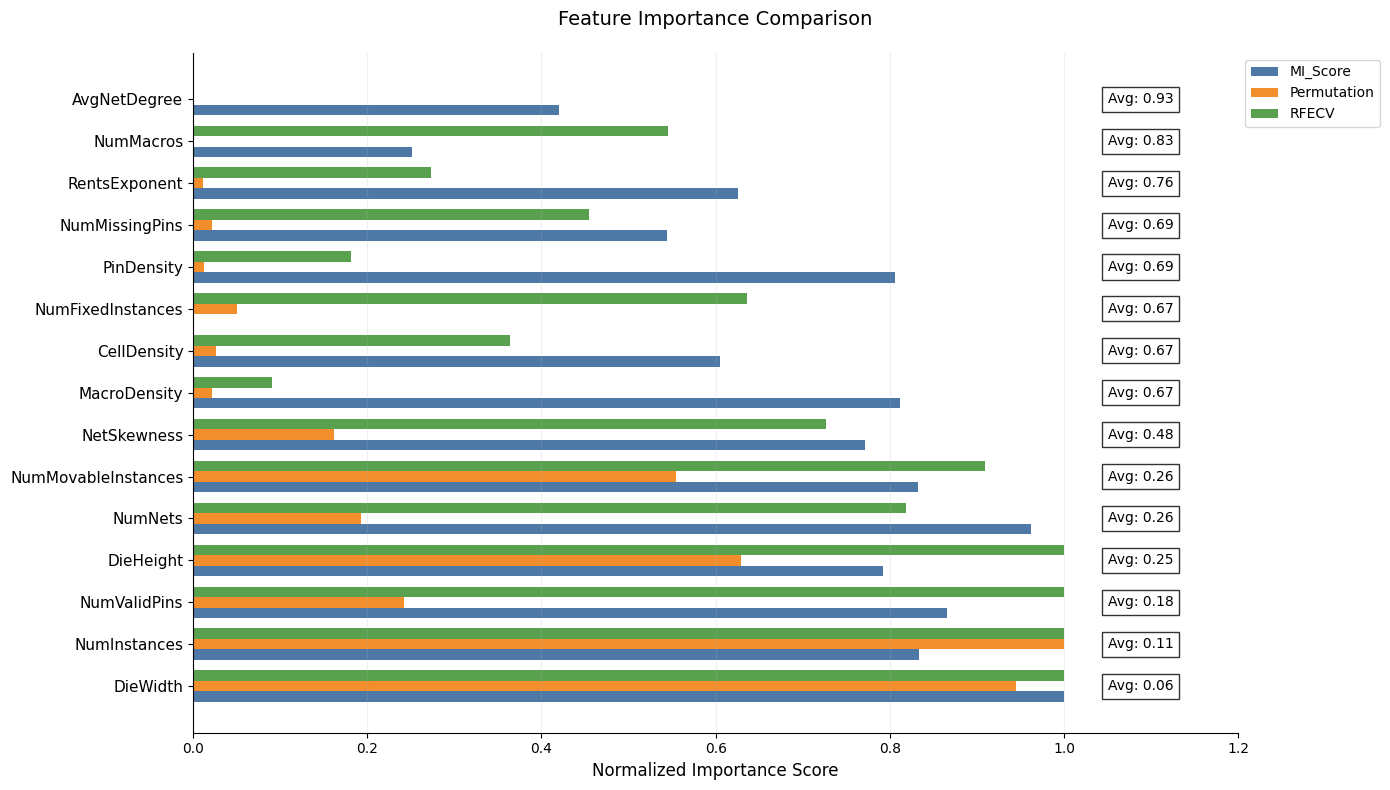


Top 5 Features:
              MI_Score  Permutation  RFECV_Rank  MI_Rank_Norm  \
DieWidth      1.384101     0.134972           1      0.000000   
NumInstances  1.234464     0.142690           1      0.214286   
NumValidPins  1.263638     0.035935           1      0.142857   
DieHeight     1.197135     0.090353           1      0.500000   
NumNets       1.350091     0.028937           3      0.071429   

              Permutation_Rank_Norm  RFECV_Rank_Norm  Average_Rank  
DieWidth                   0.071429         0.107143      0.059524  
NumInstances               0.000000         0.107143      0.107143  
NumValidPins               0.285714         0.107143      0.178571  
DieHeight                  0.142857         0.107143      0.250000  
NumNets                    0.357143         0.357143      0.261905  


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_selection import mutual_info_regression, RFECV
from sklearn.inspection import permutation_importance
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
import os

# === Create results directory ===
os.makedirs('feature_selection_results', exist_ok=True)

# === Load and prepare data ===
input_files = ["ispd18_global_features.csv", "ispd19_global_features.csv", "N28_global_features.csv"]
df_list = [pd.read_csv(f) for f in input_files]
df = pd.concat(df_list, ignore_index=True)

# Handle missing values
df = df.dropna()
df = df.drop(columns=['DEF_File', 'HPWL'])
TARGET = 'TotalWirelength'
FEATURES = [col for col in df.columns if col != TARGET]
X = df[FEATURES]
y = df[TARGET]

# Standardize features
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

# === Feature importance functions ===
def calculate_mi(X, y):
    mi = mutual_info_regression(X, y)
    return pd.Series(mi, index=X.columns, name='MI_Score').sort_values(ascending=False)

def calculate_permutation(X, y):
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X, y)
    result = permutation_importance(model, X, y, n_repeats=5, random_state=42)
    return pd.Series(result.importances_mean, index=X.columns, name='Permutation').sort_values(ascending=False)

def calculate_rfecv(X, y):
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    rfecv = RFECV(estimator=model, step=1, cv=5, scoring='neg_mean_squared_error')
    rfecv.fit(X, y)
    return pd.Series(rfecv.ranking_, index=X.columns, name='RFECV_Rank').sort_values()

# === Run analysis ===
results = {}
results['MI'] = calculate_mi(X_scaled, y)
results['Permutation'] = calculate_permutation(X_scaled, y)
results['RFECV'] = calculate_rfecv(X_scaled, y)

# === Combine results ===
df_results = pd.concat(results.values(), axis=1)

# Rank appropriately
mi_rank = df_results['MI_Score'].rank(ascending=False)
perm_rank = df_results['Permutation'].rank(ascending=False)
rfecv_rank = df_results['RFECV_Rank'].rank(ascending=True)

# Normalize ranks to 0–1 scale
n_features = len(df_results)
mi_norm_rank = (mi_rank - 1) / (n_features - 1)
perm_norm_rank = (perm_rank - 1) / (n_features - 1)
rfecv_norm_rank = (rfecv_rank - 1) / (n_features - 1)

# Store normalized ranks
df_results['MI_Rank_Norm'] = mi_norm_rank
df_results['Permutation_Rank_Norm'] = perm_norm_rank
df_results['RFECV_Rank_Norm'] = rfecv_norm_rank

# Average normalized ranks
df_results['Average_Rank'] = df_results[['MI_Rank_Norm', 'Permutation_Rank_Norm', 'RFECV_Rank_Norm']].mean(axis=1)

# Sort by best (lowest) average rank
df_results = df_results.sort_values('Average_Rank')

# Save results
df_results.to_csv('feature_selection_results/feature_ranking2.csv')

# === Plotting ===
plt.figure(figsize=(14, 8))

# Normalize scores for visualization (0–1 range)
norm_scores = df_results[['MI_Score', 'Permutation']].apply(
    lambda x: (x - x.min()) / (x.max() - x.min())
)
rfecv_norm_score = 1 - (df_results['RFECV_Rank'] - 1) / (df_results['RFECV_Rank'].max() - 1)
norm_scores['RFECV'] = rfecv_norm_score

# Plot settings
bar_width = 0.25
indices = np.arange(len(df_results))
colors = ['#4e79a7', '#f28e2b', '#59a14f']

# Plot each metric
for i, (col, color) in enumerate(zip(norm_scores.columns, colors)):
    plt.barh(indices + i * bar_width, norm_scores[col], height=bar_width,
             color=color, label=col)

# Add average rank annotations (normalized)
for i, (feat, row) in enumerate(df_results.iterrows()):
    plt.text(1.05, i + bar_width, f"Avg: {row['Average_Rank']:.2f}",
             va='center', fontsize=10, bbox=dict(facecolor='white', alpha=0.8))

# Formatting
plt.yticks(indices + bar_width, df_results.index, fontsize=11)
plt.xlabel('Normalized Importance Score', fontsize=12)
plt.title('Feature Importance Comparison', fontsize=14, pad=20)
plt.legend(bbox_to_anchor=(1, 1), loc='upper left', fontsize=10)
plt.grid(axis='x', alpha=0.2)
plt.xlim(0, 1.2)

# Remove chart borders
for spine in ['top', 'right']:
    plt.gca().spines[spine].set_visible(False)

plt.tight_layout()
plt.savefig('feature_selection_results/feature_importance_clean.png', dpi=300, bbox_inches='tight')
plt.show()

# Print top features
print("\nTop 5 Features:")
print(df_results.head(5))


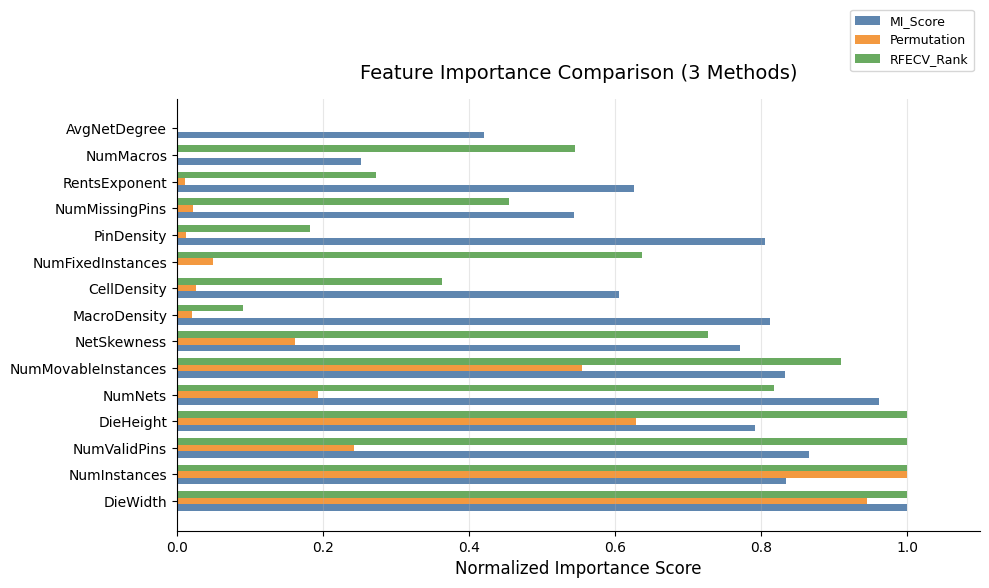

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# === Load results ===
df_results = pd.read_csv('feature_selection_results/feature_ranking2.csv', index_col=0)

# === Normalize scores for plotting ===
norm_scores = df_results.copy()

# Invert RFECV_Rank so that lower rank → higher score
norm_scores['RFECV_Rank'] = norm_scores['RFECV_Rank'].max() - norm_scores['RFECV_Rank'] + norm_scores['RFECV_Rank'].min()

# Normalize all three methods to [0,1]
norm_scores = (norm_scores[['MI_Score', 'Permutation', 'RFECV_Rank']] - 
               norm_scores[['MI_Score', 'Permutation', 'RFECV_Rank']].min()) / (
               norm_scores[['MI_Score', 'Permutation', 'RFECV_Rank']].max() - 
               norm_scores[['MI_Score', 'Permutation', 'RFECV_Rank']].min())

# === Plot settings ===
bar_width = 0.25
indices = np.arange(len(df_results))
colors = ['#4e79a7', '#f28e2b', '#59a14f']  # MI, Perm, RFECV

fig, ax = plt.subplots(figsize=(10, 6))

# Plot each metric
for i, (col, color) in enumerate(zip(norm_scores.columns, colors)):
    ax.barh(indices + i * bar_width, norm_scores[col], height=bar_width,
            color=color, label=col, alpha=0.9)

# Formatting
ax.set_yticks(indices + bar_width)
ax.set_yticklabels(df_results.index, fontsize=10)
ax.set_xlabel('Normalized Importance Score', fontsize=12)
ax.set_title('Feature Importance Comparison (3 Methods)', fontsize=14, pad=15)
ax.legend(bbox_to_anchor=(1.0, 1.05), loc='lower right', fontsize=9, frameon=True)
ax.grid(axis='x', alpha=0.3)
ax.set_xlim(0, 1.1)

# Remove chart borders
for spine in ['top', 'right']:
    ax.spines[spine].set_visible(False)

plt.tight_layout()
plt.savefig('feature_selection_results/feature_importance_3methods.png', dpi=300, bbox_inches='tight')
plt.show()


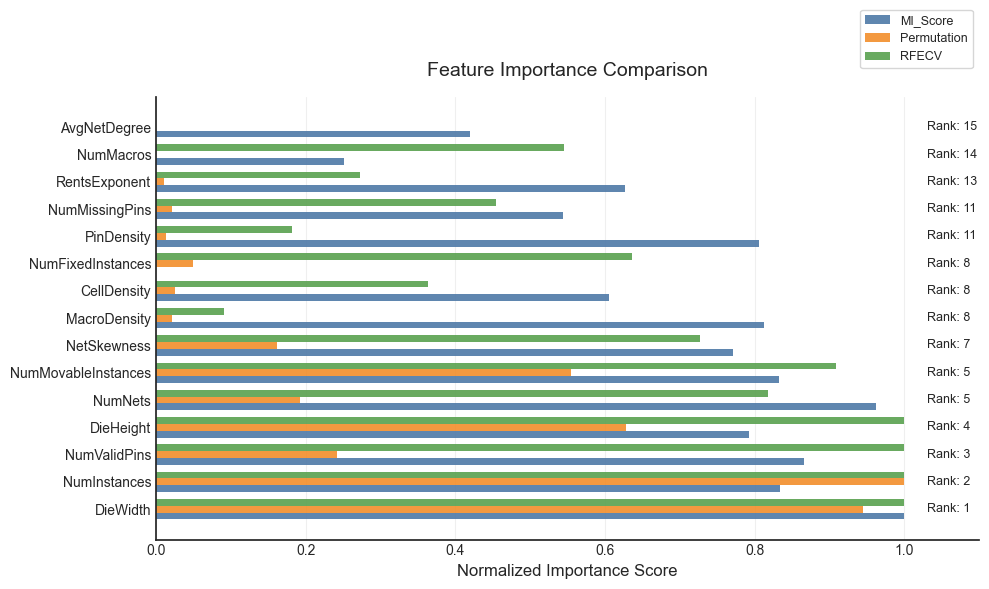

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# === Load results ===
df_results = pd.read_csv('feature_selection_results/feature_ranking2.csv', index_col=0)

# === Calculate ranks for each method ===
mi_rank = df_results['MI_Score'].rank(ascending=False)
perm_rank = df_results['Permutation'].rank(ascending=False)
rfecv_rank = df_results['RFECV_Rank'].rank(ascending=True)  # lower rank = better

# === Final rank = average of ranks from 3 methods ===
avg_rank = (mi_rank + perm_rank + rfecv_rank) / 3
df_results['Final_Rank'] = avg_rank.rank(method='min').astype(int)

# === Sort by final rank ===
df_results = df_results.sort_values('Final_Rank')

# === Normalize scores for plotting (0–1) ===
norm_scores = pd.DataFrame()
norm_scores['MI_Score'] = (df_results['MI_Score'] - df_results['MI_Score'].min()) / (df_results['MI_Score'].max() - df_results['MI_Score'].min())
norm_scores['Permutation'] = (df_results['Permutation'] - df_results['Permutation'].min()) / (df_results['Permutation'].max() - df_results['Permutation'].min())
norm_scores['RFECV'] = 1 - (df_results['RFECV_Rank'] - 1) / (df_results['RFECV_Rank'].max() - 1)  # invert so higher is better

# === Plot settings ===
plt.style.use('seaborn-v0_8-white')
bar_width = 0.25
indices = np.arange(len(df_results))
colors = ['#4e79a7', '#f28e2b', '#59a14f']  # MI, Perm, RFECV

fig, ax = plt.subplots(figsize=(10, 6))

# === Plot each method ===
for i, (col, color) in enumerate(zip(norm_scores.columns, colors)):
    ax.barh(indices + i * bar_width, norm_scores[col], height=bar_width,
            color=color, label=col, alpha=0.9)

# === Add rank annotations ===
for i, rank in enumerate(df_results['Final_Rank']):
    ax.text(1.03, i + bar_width, f"Rank: {rank}",
            va='center', fontsize=9,
            bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'))

# === Formatting ===
ax.set_yticks(indices + bar_width)
ax.set_yticklabels(df_results.index, fontsize=10)
ax.set_xlabel('Normalized Importance Score', fontsize=12)
ax.set_title('Feature Importance Comparison', fontsize=14, pad=15)
ax.legend(bbox_to_anchor=(1.0, 1.05), loc='lower right', fontsize=9, frameon=True)
ax.grid(axis='x', alpha=0.3)
ax.set_xlim(0, 1.1)

# Remove top/right borders
for spine in ['top', 'right']:
    ax.spines[spine].set_visible(False)

plt.tight_layout()
plt.savefig('feature_selection_results/feature_importance_ranked.png', dpi=300, bbox_inches='tight')
plt.show()


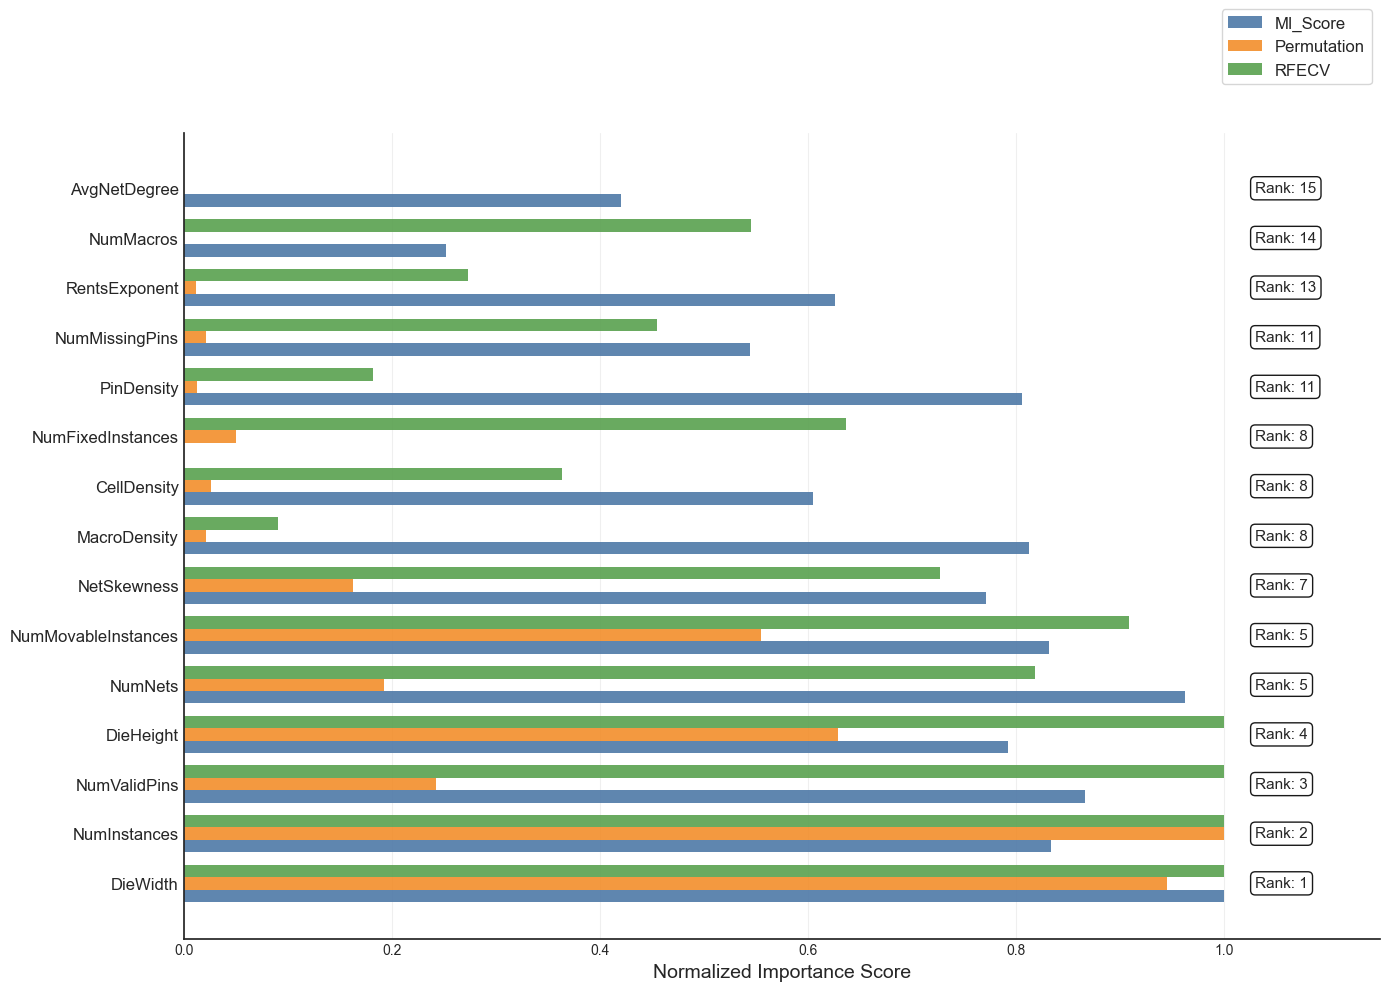

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# === Load results ===
df_results = pd.read_csv('feature_selection_results/feature_ranking2.csv', index_col=0)

# === Calculate ranks for each method ===
mi_rank = df_results['MI_Score'].rank(ascending=False)
perm_rank = df_results['Permutation'].rank(ascending=False)
rfecv_rank = df_results['RFECV_Rank'].rank(ascending=True)  # lower rank = better

# === Final rank = average of ranks from 3 methods ===
avg_rank = (mi_rank + perm_rank + rfecv_rank) / 3
df_results['Final_Rank'] = avg_rank.rank(method='min').astype(int)

# === Sort by final rank ===
df_results = df_results.sort_values('Final_Rank')

# === Normalize scores for plotting (0–1) ===
norm_scores = pd.DataFrame()
norm_scores['MI_Score'] = (df_results['MI_Score'] - df_results['MI_Score'].min()) / (df_results['MI_Score'].max() - df_results['MI_Score'].min())
norm_scores['Permutation'] = (df_results['Permutation'] - df_results['Permutation'].min()) / (df_results['Permutation'].max() - df_results['Permutation'].min())
norm_scores['RFECV'] = 1 - (df_results['RFECV_Rank'] - 1) / (df_results['RFECV_Rank'].max() - 1)  # invert so higher is better

# === Plot settings ===
plt.style.use('seaborn-v0_8-white')
bar_width = 0.25
indices = np.arange(len(df_results))
colors = ['#4e79a7', '#f28e2b', '#59a14f']  # MI, Perm, RFECV

fig, ax = plt.subplots(figsize=(14, 10))  # Bigger figure

# === Plot each method ===
for i, (col, color) in enumerate(zip(norm_scores.columns, colors)):
    ax.barh(indices + i * bar_width, norm_scores[col], height=bar_width,
            color=color, label=col, alpha=0.9)

# === Add rank annotations (full rectangle coverage) ===
for i, rank in enumerate(df_results['Final_Rank']):
    ax.text(1.03, i + bar_width, f"Rank: {rank}",
            va='center', fontsize=11,
            bbox=dict(facecolor='white', alpha=0.9, edgecolor='black', boxstyle='round,pad=0.3'))

# === Formatting ===
ax.set_yticks(indices + bar_width)
ax.set_yticklabels(df_results.index, fontsize=12)
ax.set_xlabel('Normalized Importance Score', fontsize=14)
ax.legend(bbox_to_anchor=(1.0, 1.05), loc='lower right', fontsize=12, frameon=True)
ax.grid(axis='x', alpha=0.3)
ax.set_xlim(0, 1.15)

# Remove top/right borders
for spine in ['top', 'right']:
    ax.spines[spine].set_visible(False)

plt.tight_layout()
plt.savefig('feature_selection_results/feature_importance_ranked_big.png', dpi=300, bbox_inches='tight')
plt.show()


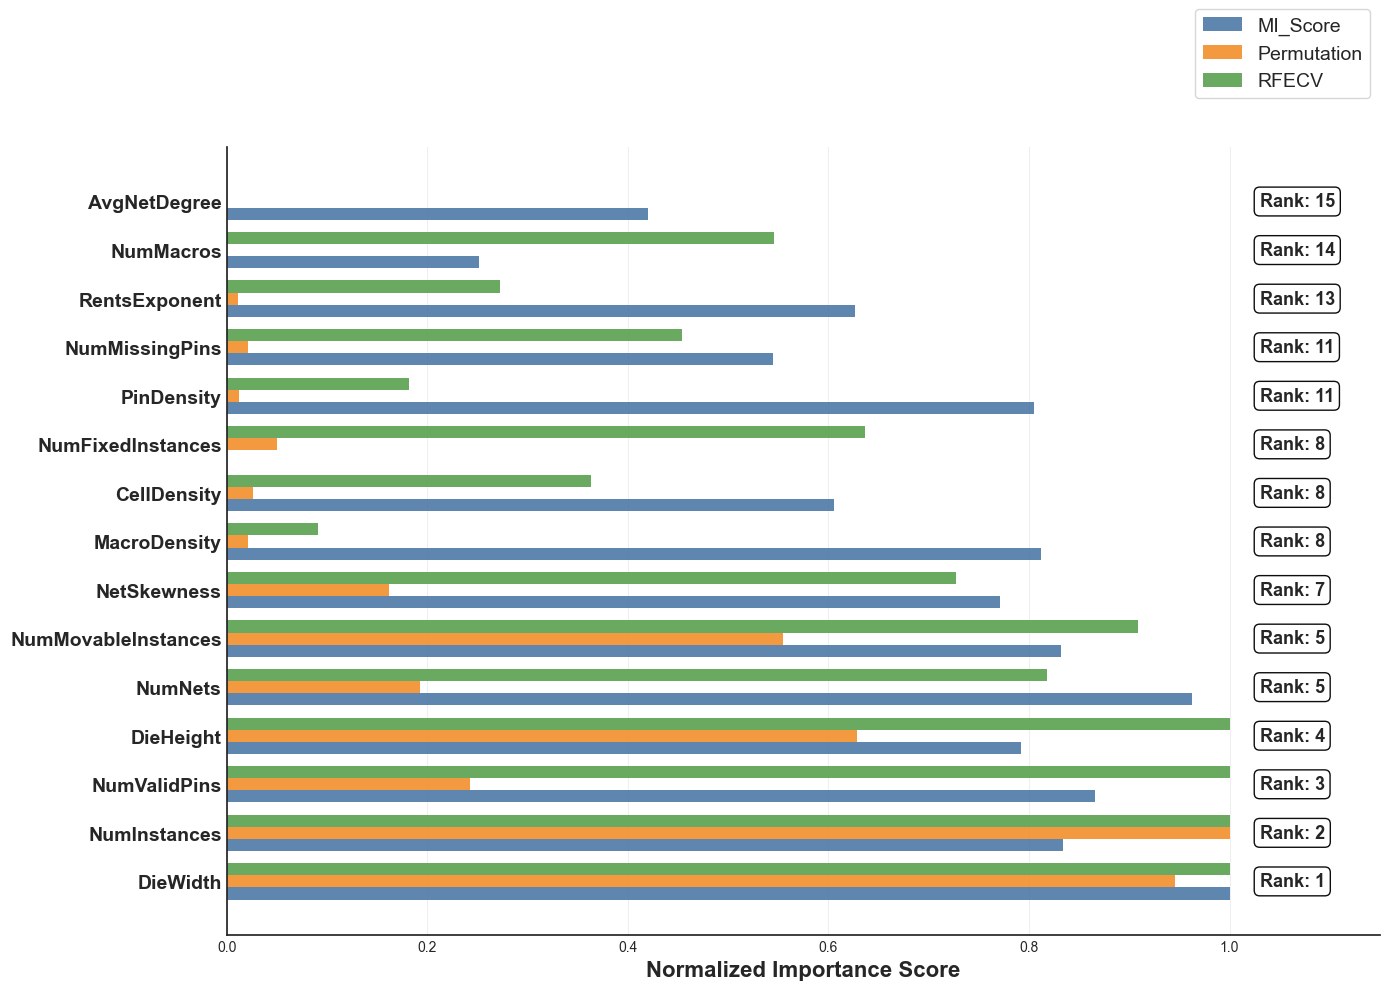

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# === Load results ===
df_results = pd.read_csv('feature_selection_results/feature_ranking2.csv', index_col=0)

# === Calculate ranks for each method ===
mi_rank = df_results['MI_Score'].rank(ascending=False)
perm_rank = df_results['Permutation'].rank(ascending=False)
rfecv_rank = df_results['RFECV_Rank'].rank(ascending=True)  # lower rank = better

# === Final rank = average of ranks from 3 methods ===
avg_rank = (mi_rank + perm_rank + rfecv_rank) / 3
df_results['Final_Rank'] = avg_rank.rank(method='min').astype(int)

# === Sort by final rank ===
df_results = df_results.sort_values('Final_Rank')

# === Normalize scores for plotting (0–1) ===
norm_scores = pd.DataFrame()
norm_scores['MI_Score'] = (df_results['MI_Score'] - df_results['MI_Score'].min()) / (df_results['MI_Score'].max() - df_results['MI_Score'].min())
norm_scores['Permutation'] = (df_results['Permutation'] - df_results['Permutation'].min()) / (df_results['Permutation'].max() - df_results['Permutation'].min())
norm_scores['RFECV'] = 1 - (df_results['RFECV_Rank'] - 1) / (df_results['RFECV_Rank'].max() - 1)  # invert so higher is better

# === Plot settings ===
plt.style.use('seaborn-v0_8-white')
bar_width = 0.25
indices = np.arange(len(df_results))
colors = ['#4e79a7', '#f28e2b', '#59a14f']  # MI, Perm, RFECV

fig, ax = plt.subplots(figsize=(14, 10))  # Bigger figure

# === Plot each method ===
for i, (col, color) in enumerate(zip(norm_scores.columns, colors)):
    ax.barh(indices + i * bar_width, norm_scores[col], height=bar_width,
            color=color, label=col, alpha=0.9)

# === Add rank annotations (full rectangle coverage) ===
for i, rank in enumerate(df_results['Final_Rank']):
    ax.text(1.03, i + bar_width, f"Rank: {rank}",
            va='center', fontsize=13, fontweight='bold',
            bbox=dict(facecolor='white', alpha=0.95, edgecolor='black', boxstyle='round,pad=0.3'))

# === Formatting ===
ax.set_yticks(indices + bar_width)
ax.set_yticklabels(df_results.index, fontsize=14, fontweight='bold')
ax.set_xlabel('Normalized Importance Score', fontsize=16, fontweight='bold')
ax.legend(bbox_to_anchor=(1.0, 1.05), loc='lower right', fontsize=14, frameon=True)
ax.grid(axis='x', alpha=0.3)
ax.set_xlim(0, 1.15)

# Remove top/right borders
for spine in ['top', 'right']:
    ax.spines[spine].set_visible(False)

plt.tight_layout()
plt.savefig('feature_selection_results/feature_importance_ranked_big.png', dpi=300, bbox_inches='tight')
plt.show()
